# Final Project, Numerical Analysis 2018-2019

Here is the final project as developed by Federico Pigozzi, DSSC. 

NOTE: in all the following tests, I decided to use the 'time' module instead of the 'timeit' one. The reason is that the latter does not include the time required by the garbage collector of Python, which I deem a fundamental part of performance evaluation since it is related to memory usage.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
from math import sqrt
import functools
from scipy import linalg
from time import time

In [237]:
arc = load("mnist.npz")

x_train = arc["arr_0"]
y_train = arc["arr_1"]
x_test = arc["arr_2"]
y_test = arc["arr_3"]

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


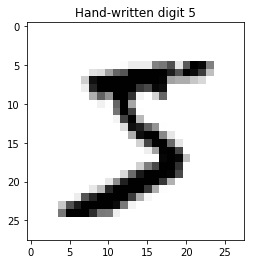

In [5]:
N=0
imshow(x_train[N], cmap="gray_r")
_ = title("Hand-written digit " + str(y_train[N]))

# Assignment 1
Three basic distances have been implemented, in the most efficient possible way. Notice that, in order to do so, I was able to exploit the numpy.linalg.norm routine which by default computes the d_two distance that has been required.

In [6]:
def d_linfty(a, b):
    '''
    Computes the maximum of the differences in absolute value.
    '''
    return numpy.amax(numpy.abs(b - a)) #amax returns the maximum argument of the array

def d_one(a, b):
    '''
    Computes the sum of the absolute values of the differences.
    '''
    return numpy.sum(numpy.abs(b - a))

def d_two(a, b):
    '''
    Computes the Frobenius norm.
    '''
    return numpy.linalg.norm(b - a) #Frobenius norm of b - a, which is the default of the linalg.norm routine

# Assignment 2
A function distance_matrix has been implemented, which fulfills the requirements of this assignment. In order to avoid repeated computations of the same distance, I put in place the following algorithm: consider a distance matrix as a block matrix of the form [[A, B], [B, D]]. It is symmetric, so B gets mirrored on the other side of the diagonal, while both A and D are symmetric by themselves. Notice that computing the distance matrix for 100, 200, 400, 800, 1600 yields some repeated calculations, since the distance matrix for 100 is going to be the A block for the 200 one, which is going to be the A block for the 400 one, and so on. As a result, we can solve the problem in a recursive way, caching each time the result, which will become available for subsequent rounds in constant time. 

In order to cache the result, I decorated the function with lru_cache() defined in the standard library. Basically, it internally stores a dictionary of args: output pairs, where args are the arguments passed to a given call. Subsequently, the algorithm works as follows: the base case is given by the 100x100 matrix, which is solved through a slightly modified version of the naive implementation. Of course, this approach is not scalable to sizes smaller than 100 or not divisible by 100, but I decided to do everything that was necessary to get maximum performance. Subsequently, the B block is solved (again with the naive procedure), and the result copied to its twin counterpart. Then, we have the two recursive calls to the A and D blocks.
  
  In the following there is also a function dedicated to the naive version, used for benchmarking. As can be seen from the tests below, the speedup has been rather significant.
  
NOTE: it is true that the redundancy problem could have been avoided by computing the (naive) distance matrix only for the maximum (1600) size, but still I decided to pursue this road as an extra challenge and also for scalability reasons (e.g. if we may want to compute the distance matrix for 3200, one quarter of the job will have already been done). Additionally, in the following assignments there will be tests on the distance_matrix function evaluated over different sizes (for different goals), so the caching strategy will turn out useful.

In [7]:
@functools.lru_cache()    #decorator to cache the results
def distance_matrix(s, n, dist):
    '''
    Computes the distance matrix, given a dist function and n the size of the matrix. s is to keep
    track of which portion of the matrix we are recursively solving.
    '''
    length = n - s
    D = numpy.zeros((length, length))    #so that we can skip filling the diagonal, which clearly is zero
    #base case: the matrix is 100x100
    if length == 100:
        _i = 0    #_i and _j are the "local indexes", i and j the "real"
        for i in range(s, n):
            _j = 0
            for j in range(s, i):    #up to i because the matrix is symmetric. Reduces complexity by half.
                q = dist(x_train[i], x_train[j])
                D[_i, _j], D[_j, _i] = q, q
                _j += 1
            _i += 1
        return D
    #end base case
    half = (n + s) // 2
    _i = half - s
    for i in range(half, n):
        _j = 0
        for j in range(s, half):    #since the matrix is symmetric
            q = dist(x_train[i], x_train[j])
            D[_i, _j], D[_j, _i] = q, q
            _j += 1
        _i += 1
    half -= s    #to avoid repeated computations of half - s
    D[:half, :half] = distance_matrix(s, half+s, dist)   #recursively solve A block
    D[half:, half:] = distance_matrix(half+s, n, dist)   #recursively solve D block
    return D

#naive version
def naive_distance_matrix(n, dist):
    '''
    Naive implementation that only exploits symmetry
    '''
    D = numpy.zeros((n, n))
    for i in range(n):
        for j in range(i):
            q = dist(x_train[i], x_train[j])
            D[i, j], D[j, i] = q, q
    return D

In [8]:
naive_results = list()
new_results = list()
x = [100, 200, 400, 800, 1600] #sizes to be investigated
temp_times = list() # to store repeated measurements of the same round

for num in x:
    for _ in range(10): #repeat measurement to sift out fluctuations
        start = time()
        _ = naive_distance_matrix(num, d_linfty)
        temp_times.append(time() - start)
    naive_results.append(sum(temp_times)/len(temp_times))
    temp_times = []
    for _ in range(10): #repeat measurement
        start = time()
        _ = distance_matrix(0, num, d_linfty)
        temp_times.append(time() - start)
    new_results.append(sum(temp_times)/len(temp_times))
    temp_times = []

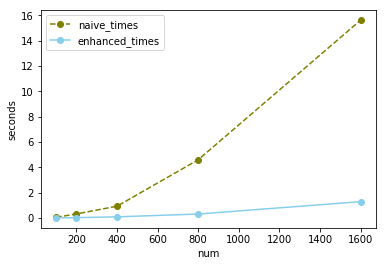

In [12]:
#plot the results

plot(x, naive_results, label="naive_times", marker="o", color="olive", linestyle="dashed")
plot(x, new_results, label="enhanced_times", marker="o", color="skyblue")
xlabel("num")
ylabel("seconds")
_ = legend()

# Assignment 3
The three distance matrices have been computed and displayed using imshow

CPU times: user 17.2 ms, sys: 2.98 ms, total: 20.2 ms
Wall time: 17.6 ms


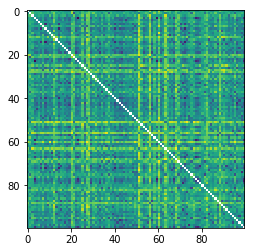

In [484]:
%%time

D1 = distance_matrix(0, 100, d_one)
_ = imshow(D1)

CPU times: user 17.1 ms, sys: 2.83 ms, total: 19.9 ms
Wall time: 17.4 ms


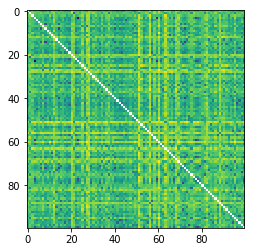

In [483]:
%%time

D2 = distance_matrix(0, 100, d_two)
_ = imshow(D2)

CPU times: user 19.7 ms, sys: 2.96 ms, total: 22.7 ms
Wall time: 20.2 ms


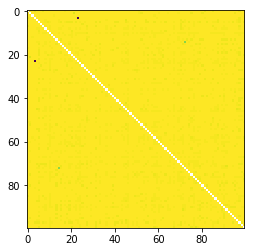

In [481]:
%%time

Dinfty = distance_matrix(0, 100, d_linfty)
_ = imshow(Dinfty)

# Assignment 4
A function that evaluates the error rate has been implemented. In particular, it returns the fraction of misclassifications, applying as decision rule the digit of the image having the smallest distance. To achieve this task, the numpy function of argmin has been used, which turned out to be much more efficient than anything I could implement by hand. In order to make sure the distance from the image under consideration was not used (being 0, which is the smallest possible distance), I preemptively set the diagonal to float("inf").

In [9]:
def inefficiency(dist_matrix):
    '''
    Returns the fraction of misclassifications, according to a "smallest distance" classification
    rule based on dist_matrix, the matrix of distances.
    '''
    n, _ = dist_matrix.shape
    error_counter = 0
    numpy.fill_diagonal(dist_matrix, float("inf")) #got negligible speedup over in-loop version, but still more readable and Pythonic
    for i in range(n):
        j = numpy.argmin(dist_matrix[i,:])
        error_counter += (y_train[i] != y_train[j]) #Avoiding if conditions always gains performance
    return error_counter / n

# Assignment 5
Here are the error rates for the three distances, and for the different matrix sizes

In [498]:
%%time

ans = numpy.zeros((5,3))
for index, num in enumerate([100, 200, 400, 800, 1600]):
    ans[index, 0] = inefficiency(distance_matrix(0, num, d_linfty))
    ans[index, 1] = inefficiency(distance_matrix(0, num, d_one))
    ans[index, 2] = inefficiency(distance_matrix(0, num, d_two))

CPU times: user 115 ms, sys: 129 ms, total: 244 ms
Wall time: 235 ms


In [499]:
print(ans)

[[0.58     0.17     0.17    ]
 [0.52     0.145    0.135   ]
 [0.4425   0.15     0.135   ]
 [0.4      0.145    0.12875 ]
 [0.369375 0.1025   0.09375 ]]


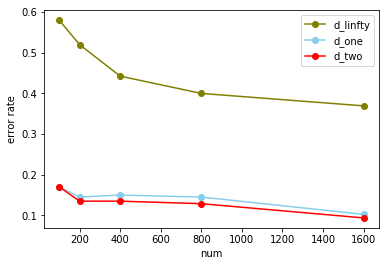

In [480]:
x = [100, 200, 400, 800, 1600]
plot(x, ans[:,0], label="d_linfty", marker="o", color="olive")
plot(x, ans[:,1], label="d_one", marker="o", color="skyblue")
plot(x, ans[:,2], label="d_two", marker="o", color="red")
xlabel("num")
ylabel("error rate")
_ = legend()

# Assignment 6
The following functions implement the H1 distance as described in the assignment. The first step was to normalize the images dividing them by their integral. Of course, an integral is defined for a function. So, the most rigorous way to proceed would have been to interpolate the image arrays so that they could be represented by function objects. A nice way to go could have been to define an "interpolate" function which, given an image, returns a function object (like a RectBivariateSpline object) that can be called just like a function. Nevertheless, I deemed this approach to be prohibitively expensive from the computational point of view at the very beginning.

Luckily, there exist a set of functions in the scipy.integrate module that work on fixed samples. In fact, we can think of each pixel as the evaluation of the underlying unknown function at a given node. I focused my attention on two of them, integrate.trapz (which performs the trapezoidal rule) and integrate.simps (which applies Simpson's rule). At the end, I realized that from a conceptual point of view the procedure was the same as summing all the pixel values. I rested on numpy.sum because of its quickness. Below are the timings.

In [504]:
from scipy.integrate import simps, trapz

In [493]:
test = x_train[0]
simps_results = list()
trapz_results = list()
sum_results = list()
x = list(range(100))

temp_times = list() # to store repeated measurements of the same round

for num in x:
    for _ in range(10): #repeat measurement to sift out fluctuations
        start = time()
        _ = simps(simps(test)) # we need to integrate once for each dimension
        temp_times.append(time() - start)
    simps_results.append(sum(temp_times)/len(temp_times))
    temp_times = []
    for _ in range(10): #repeat measurement
        start = time()
        _ = trapz(trapz(test)) # we need to integrate once for each dimension
        temp_times.append(time() - start)
    trapz_results.append(sum(temp_times)/len(temp_times))
    temp_times = []
    for _ in range(10):
        start = time()
        _ = numpy.sum(test)
        temp_times.append(time() - start)
    sum_results.append(sum(temp_times)/len(temp_times))
    temp_times = []

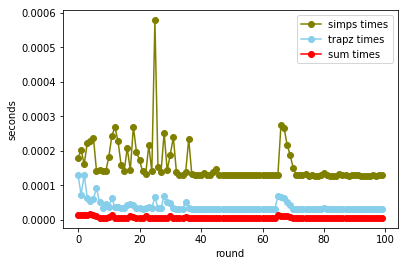

In [495]:
plot(x, simps_results, label="simps times", marker="o", color="olive")
plot(x, trapz_results, label="trapz times", marker="o", color="skyblue")
plot(x, sum_results, label="sum times", marker="o", color="red")
xlabel("round")
ylabel("seconds")
_ = legend()

As we can see, the trapezoidal formula turns out to be much faster than Simpson's rule, but slower than the call to numpy.sum. Finally, let's check the correctness of the procedure. Notice the two functions have different rounding policies (numpy.sum truncates to the fourth digit). The result is the same up to the fourth decimal digit.

In [539]:
print(round(trapz(trapz(test)), 4) == round(numpy.sum(test), 4))

True


The assignment then asks to compute the gradient of an image. In order to do so, I decided to use the highly optimized version given by numpy, which returns the derivative along x and y axes in a tuple. According to the numpy documentation (see https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html), the gradient is computed using central differences in the interior points and one-sides (forward or backwards) differences at the boundaries. The returned gradient hence has the same shape as the input array, so we avoid an unpleasant empty effect on the boundaries (since, of course, two values are necessary to compute a finite difference).

Moreover, it turns out that the gradient is a linear operator, so Grad(a - b) = Grad(a) - Grad(b). As a result, the gradients can be computed outside of the distance function once and for all, avoiding unnecessary computations.

In [481]:
def d_h1(i, j):
    '''
    Computes the H1 distance between two images.
    '''
    a = norm_train[i]   #norm and G store normalized images and gradients, see cells below
    b = norm_train[j]
    D = G[i] - G[j]
    #[0] is derivative along x, [1] is y
    return numpy.sqrt(numpy.sum(numpy.square(D[0]) + numpy.square(D[1]) + numpy.square(a - b)))

def naive_d_h1(i, j):
    '''
    Computes the H1 distance, does not exploit precomputing.
    '''
    f1 = x_train[i]
    f2 = x_train[j]
    a = f1 / numpy.sum(f1)
    b = f2 / numpy.sum(f2)
    d = a - b
    D = numpy.gradient(d)
    #[0] is derivative along x, [1] is y
    return numpy.sqrt(numpy.sum(numpy.square(D[0]) + numpy.square(D[1]) + numpy.square(d)))

We can enhance the procedure by precomputing all the normalized arrays.

In [477]:
%%time

n = 1600    #the maximum we will need
norm_train = numpy.copy(x_train[:n])
norm_train /= numpy.array([numpy.sum(x) for x in norm_train]).reshape(n, 1, 1)

CPU times: user 39.4 ms, sys: 8.71 ms, total: 48.1 ms
Wall time: 25.1 ms


In [201]:
%%time

n = 1600
G = numpy.copy(x_train[:n])
G = array([numpy.gradient(x) for x in G])

CPU times: user 243 ms, sys: 9.78 ms, total: 253 ms
Wall time: 140 ms


In [520]:
#same as the original one, but calls "dist" with two indices, not images

@functools.lru_cache()
def distance_matrix_for_h1_and_boost(s, n, dist):
    '''
    Computes the distance matrix exploiting the h1-specific enhancement.
    '''
    length = n - s
    D = numpy.zeros((length, length))
    if length == 100:
        _i = 0
        for i in range(s, n):
            _j = 0
            for j in range(s, i):
                q = dist(i, j)
                D[_i, _j], D[_j, _i] = q, q
                _j += 1
            _i += 1
        return D
    half = (n + s) // 2
    _i = half - s
    for i in range(half, n):
        _j = 0
        for j in range(s, half):
            q = dist(i, j)
            D[_i, _j], D[_j, _i] = q, q
            _j += 1
        _i += 1
    half -= s
    D[:half, :half] = distance_matrix_for_h1_and_boost(s, half+s, dist)
    D[half:, half:] = distance_matrix_for_h1_and_boost(half+s, n, dist)
    return D

We will now benchmark the performance gain in precomputing normalized images and gradients.

In [285]:
naive_results = list()
new_results = list()
x = [100, 200, 400, 800, 1600] #sizes to be investigated
temp_times = list() # to store repeated measurements of the same round

for num in x:
    for _ in range(10): #repeat measurement to sift out fluctuations
        start = time()
        _ = distance_matrix_for_h1_and_boost(0, num, naive_d_h1)
        temp_times.append(time() - start)
    naive_results.append(sum(temp_times)/len(temp_times))
    temp_times = []
    for _ in range(10): #repeat measurement
        start = time()
        _ = distance_matrix_for_h1_and_boost(0, num, d_h1)
        temp_times.append(time() - start)
    new_results.append(sum(temp_times)/len(temp_times))
    temp_times = []

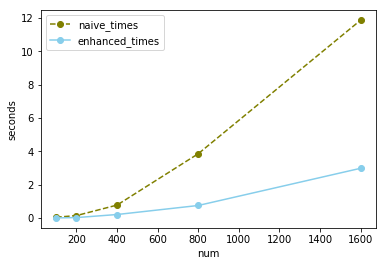

In [286]:
#plot the results

plot(x, naive_results, label="naive_times", marker="o", color="olive", linestyle="dashed")
plot(x, new_results, label="enhanced_times", marker="o", color="skyblue")
xlabel("num")
ylabel("seconds")
_ = legend()

As we can see, there is an obvious advantage in precomputing.

CPU times: user 435 ms, sys: 4.47 ms, total: 440 ms
Wall time: 438 ms


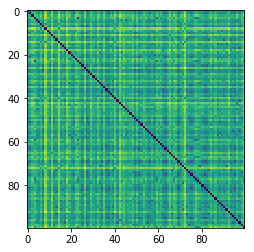

In [270]:
%%time

h1 = distance_matrix_for_h1_and_boost(0, 100)
_ = imshow(h1)

In [504]:
%%time

ans = numpy.append(ans, numpy.zeros((5,1)), axis=1)
for index, num in enumerate([100, 200, 400, 800, 1600]):
    ans[index, 3] = inefficiency(distance_matrix_for_h1_and_boost(0, num, d_h1))

CPU times: user 2min 21s, sys: 502 ms, total: 2min 22s
Wall time: 2min 23s


In [506]:
print(ans)

[[0.58     0.17     0.17     0.23    ]
 [0.52     0.145    0.135    0.175   ]
 [0.4425   0.15     0.135    0.145   ]
 [0.4      0.145    0.12875  0.12125 ]
 [0.369375 0.1025   0.09375  0.099375]]


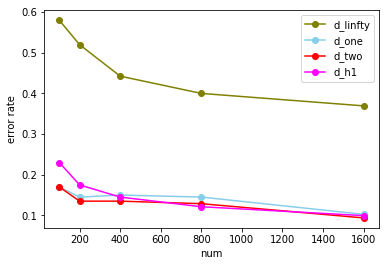

In [273]:
x = [100, 200, 400, 800, 1600]
plot(x, ans[:,0], label="d_linfty", marker="o", color="olive")
plot(x, ans[:,1], label="d_one", marker="o", color="skyblue")
plot(x, ans[:,2], label="d_two", marker="o", color="red")
plot(x, ans[:,3], label="d_h1", marker="o", color="magenta")
xlabel("num")
ylabel("error rate")
_ = legend()

As we can see, the new h1 distance stands sort in between the d_one and d_two distances.

# Assignment 7
I have written a function that computes the Monge-Ampere distance. Of course, we will use the pre-computed normalized images for efficiency reasons. Then, we have the problem of how to calculate the Laplacian of the function phi. Notice that the formulation given resambles closely the Poisson problem analyzed in class. As a result, we will look for a solution (the function phi in the assignment) using the Galerkin method and finite elements approximations. Finite differences approximations are a choice, but the requirements on the right-hand side function (a - b) are very strict in general. 

At the bottom of the assignment there is the implementation of a phi() routine which returns the evaluation of the bases functions we made use for the finite elements approximations. I included it just for the sake of completeness, but the actual function does not make use of it because the bases are always one at the points.

In order to make solving linear systems as efficient as possible, I decided to pre-compute the factorization of the stiffness matrix used in the finite elements approximation. Instead of opting for the Gaussian factorization, I decided to implement the Thomas Algorithm explained in the lab lectures. Basically, it is a simplified form of Gaussian elimination that can be used to solve tri-diagonal systems of equations, with the advantage that it is O(n) against the O(n^3) of the traditional Gaussian factorization. In addition, I decorated the function with the jit decorator coming from the very useful numba library, so that the function gets compiled to machine code for execution and all or part of the code can run at native machine code speed. Numba works best on code that uses numpy arrays and loops. Subsequently, this factorization is used in conjunction with scipy.linalg.lu_solver. On the other side, numpy.linalg.solve would have factorized the matrix each time (this is exactly what the naive implementation does below, and tests have been made).

In [596]:
#Assemble stiffness matrix. The boundary condition is fulfilled by restricting to the interior points, which is like
#setting to 0 on the boundary

n = 28*28
B = np.zeros((n,n)) + numpy.eye(n, n, 1) + numpy.eye(n, n, -1)
numpy.fill_diagonal(B, -4)

numpy.linalg.cond(B)   #it looks like a nice matrix

2.99996796782931

In [536]:
from numba import jit

@jit(nopython=True)
def thomas(A):
    '''
    Computes the LU factorization of the matrix using Thomas Algorithm.
    Returns a matrix whose lower and upper triangular parts correspond to
    L and U respectively. The diagonal of L, which is equal to 1, has been
    suppressed. The algorithm in-place was not compatible with numba.
    '''
    n, m = A.shape
    L = numpy.zeros((n,m))
    U = numpy.zeros((n,m))
    U[0, 0] = A[0, 0]
    for i in range(1, n):
        k = i-1    #avoid computing it over and over again
        U[k, i] = A[k, i]
        L[i, k] = A[i, k] / U[k,k]
        U[i, i] = A[i, i] - L[i, k]*U[k,i]
    L += U
    return L

In [347]:
#check correctness of the algorithm

LU, piv = linalg.lu_factor(B)
LU1 = thomas(B)
print(all(LU == LU1))

True


In [495]:
x = [10, 100, 200, 400, 600, 800, 1000]
naive_results = list()
thomas_results = list()
temp_times = list()

for n in x:
    B = np.zeros((n,n)) + numpy.eye(n, n, 1) + numpy.eye(n, n, -1)
    numpy.fill_diagonal(B, 4)
    for _ in range(10): #repeat measurement to sift out fluctuations
        start = time()
        _ = linalg.lu_factor(B)
        temp_times.append(time() - start)
    naive_results.append(sum(temp_times)/len(temp_times))
    temp_times = []
    for _ in range(10): #repeat measurement
        start = time()
        _ = thomas(B)
        temp_times.append(time() - start)
    thomas_results.append(sum(temp_times)/len(temp_times))
    temp_times = []

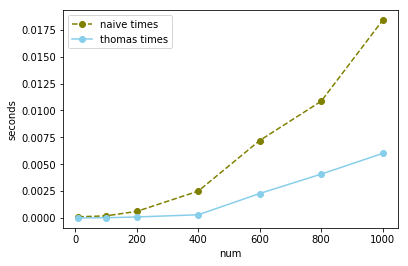

In [496]:
plot(x, naive_results, label="naive times", marker="o", color="olive", linestyle="dashed")
plot(x, thomas_results, label="thomas times", marker="o", color="skyblue")
xlabel("num")
ylabel("seconds")
_ = legend()

In [558]:
n = 28*28
B = np.zeros((n,n)) + numpy.eye(n, n, 1) + numpy.eye(n, n, -1)
numpy.fill_diagonal(B, -4)

LU = thomas(B)
piv = numpy.zeros((n,))   #dummy permutation vector for the call to linalg.lu_solve

In [598]:
def d_boost(i, j):
    '''
    Computes the Monge-Ampere distance among two normalized images.
    '''
    a = norm_train[i]
    b = norm_train[j]
    f = a - b
    r = array([[numpy.sum(f[i,j]) for i in range(f.shape[0])] for j in range(f.shape[1])]).ravel()
    u = linalg.lu_solve((LU, piv), r).reshape(a.shape)
    D = numpy.gradient(u)
    return numpy.sum((a + b)*(numpy.square(D[0]) + numpy.square(D[1])))

def naive_d_boost(i, j):
    '''
    Computes the Monge-Ampere distance among two normalized images,
    does not exploit precomputation.
    '''
    a = norm_train[i]
    b = norm_train[j]
    f = a - b
    r = array([[numpy.sum(f[i,j]*phi(i, j, i, j)) for i in range(f.shape[0])] for j in range(f.shape[1])]).ravel() 
    u = numpy.linalg.solve(B, r).reshape(a.shape)
    D = numpy.gradient(u)
    return numpy.sum((a + b)*(numpy.square(D[0]) + numpy.square(D[1])))

Let's do some benchmarking now

In [521]:
%time _ = distance_matrix_for_h1_and_boost(0, 100, naive_d_boost)

CPU times: user 3min 45s, sys: 8.34 s, total: 3min 53s
Wall time: 2min 9s


In [599]:
%time _ = distance_matrix_for_h1_and_boost(0, 100, d_boost)

CPU times: user 1min 25s, sys: 5.08 s, total: 1min 30s
Wall time: 48.1 s


As we can see, the optimized version is undoubtedly better. If we were to go farther, we would likely see the naive implementation to behave cubically, with the optimized one behaving quadratically.

In [313]:
def euclidean(a, b, c, d):
    '''
    Returns the Euclidean distance between two two-dimensional points.
    '''
    return math.sqrt((a - b)**2 + (c - d)**2)   #this formula turned out to be faster than numpy.norm, but I omitted the proof for brevity

In [321]:
def phi(xi, yi, x, y):
    '''
    Evaluates the phi bases functions at the point x, y with respect
    to the center xi, yi.
    '''
    xi_a, xi_b, yi_a, yi_b = xi-1, xi+1, yi-1, yi+1    #avoid repeated computations
    if xi_a < x <= xi:
        if yi_a < y <= yi:
            return euclidean(x, xi_a, y, yi_a)
        elif yi <= y < yi_b:
            return euclidean(x, xi_a, y, yi_b)
        else:
            return 0
    elif xi <= x < xi_b:
        if yi_a < y <= yi:
            return euclidean(x, xi_b, y, yi_a)
        elif yi <= y < yi_b:
            return euclidean(x, xi_b, y, yi_b)
        else:
            return 0
    else:
        return 0

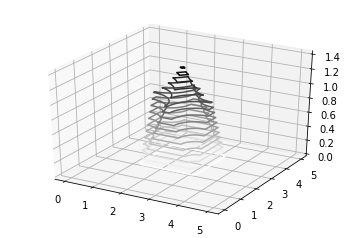

In [325]:
#plot the basis phi over a two-dimensional linspace. The output should be a cone

from mpl_toolkits import mplot3d

n = 5.0
m = 1025
x = y = linspace(0, n, m)
X, Y = numpy.meshgrid(x, y)
ax = pyplot.axes(projection="3d")
Z = numpy.array([[phi(n/2.0, n/2.0, X[i,j], Y[i,j]) for i in range(m)] for j in range(m)])
_ = ax.contour3D(X, Y, Z, 20, cmap="binary")

In [ ]:
ans = numpy.append(ans, numpy.zeros((5,1)), axis=1)
for index, num in enumerate([100, 200, 400, 800, 1600]):
    ans[index, 4] = inefficiency(distance_matrix_for_h1_and_boost(0, num, d_boost))

In [621]:
print(ans)

[[0.58     0.17     0.17     0.23     0.25    ]
 [0.52     0.145    0.135    0.175    0.205   ]
 [0.4425   0.15     0.135    0.145    0.18    ]
 [0.4      0.145    0.12875  0.12125  0.1577  ]
 [0.369375 0.1025   0.09375  0.099375 0.1235  ]]


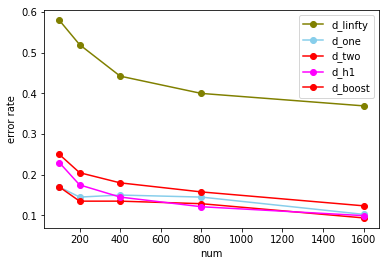

In [622]:
x = [100, 200, 400, 800, 1600]
plot(x, ans[:,0], label="d_linfty", marker="o", color="olive")
plot(x, ans[:,1], label="d_one", marker="o", color="skyblue")
plot(x, ans[:,2], label="d_two", marker="o", color="red")
plot(x, ans[:,3], label="d_h1", marker="o", color="magenta")
plot(x, ans[:,4], label="d_boost", marker="o", color="red")
xlabel("num")
ylabel("error rate")
_ = legend()

The new distance performs slightly worse than the top three, while keeping itself well below the d_linfty.

# Assignment 8 - optional
I set up a function that does what required by the assignment. Notice that in order to compute the errors, the trees have been initialized outside of the function to make them reusable with a different number of neighbors. Additionally, in order to make the experiment runnable on my PC, I reduced the problem sizes to a hundred of the original (and unfortunately, sklearn has not been made available on Ulysses). The execution time for the original sizes exceeded 1 hour in the very first iterations. Moreover, I searched for an optimal value of the parameter leaf_size and found it to be near 50. leaf_size controls when the search becomes a brute-force one, and so it depends on the tradeoff between computing our distance and descending the tree. Probably, since the default was set to 40, our distances are sort of cheaper than the typical one, but this is just speculation. Enabling breadth-first search and dualtree execution revealed to deliver slight performance gains as well.

In [612]:
from sklearn.neighbors import BallTree

def ball(tree, neighbors):
    error_counter = 0
    m = x_test.shape[0]
    indexes = tree.query(x_test.reshape(m, 28*28), k=neighbors, return_distance=False, dualtree=True, breadth_first=True)
    if neighbors < 2:
        for i, idx in enumerate(indexes):
            error_counter += (y_test[i] != y_train[idx])
    else:
        for i, idx in enumerate(indexes):
            candidates = numpy.array([y_train[j] for j in idx])
            error_counter += (y_test[i] != numpy.argmax(numpy.bincount(candidates)))
    return error_counter / m        

In [ ]:
res = {"d_linfty": [], "d_one": [], "d_two": []}
x = [32, 64, 128, 256, 512]
Trees = list()

for dist in res1:
    for num in x:
        tree = BallTree(x_train[:num].reshape(num, -1), leaf_size=50, metric="pyfunc", func=eval(dist))
        res1[dist].append(ball(tree, 1))
        Trees.append(tree)   #will turn out useful later

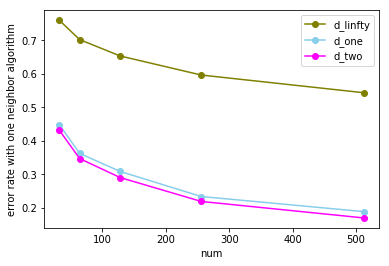

In [610]:
plot(x, res1["d_linfty"], label="d_linfty", marker="o", color="olive")
plot(x, res1["d_one"], label="d_one", marker="o", color="skyblue")
plot(x, res1["d_two"], label="d_two", marker="o", color="magenta")
xlabel("num")
ylabel("error rate with one neighbor algorithm")
_ = legend()

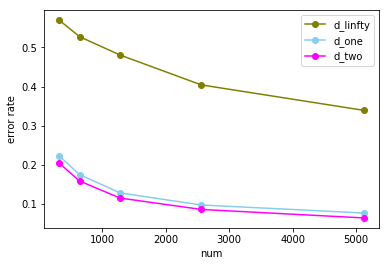

In [546]:
#this comes from a previous run of mine when I managed to use just one tenth of the original sizes. As we can see, the
#trajectories are almost the same, which justifies my choice to reduce the problem size

plot(x, res["d_linfty"], label="d_linfty", marker="o", color="olive")
plot(x, res["d_one"], label="d_one", marker="o", color="skyblue")
plot(x, res["d_two"], label="d_two", marker="o", color="magenta")
xlabel("num")
ylabel("error rate with one neighbor algorithm")
_ = legend()

As we can see, the behavior of the error rate closely mimicks the one obtained using our custom algorithm. Our last two distances have been omitted for computational reasons, but by monothonicity I suppose their behavior would have been the same as before. In fact, the Ball Tree and our simple classifier follow the same nearest neighbor-inspired logic, with the distinction that ours performs an exhaustive search, while the Ball Tree is guided by a rather effective heuristic.

In [ ]:
res2 = {"d_linfty": [], "d_one": [], "d_two": []}
x = [32, 64, 128, 256, 512]
count = 0   #to know which tree we need

#run the simulation using 3 neighbors as decision rule
for dist in res2:
    for num in x:
        tree = Trees[count]
        res2[dist].append(ball(tree, 3))
        count += 1
        print("iter")

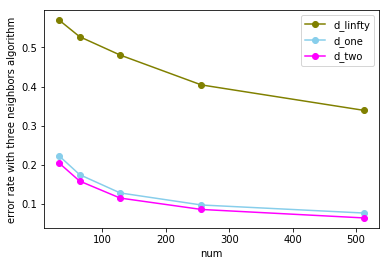

In [614]:
plot(x, res["d_linfty"], label="d_linfty", marker="o", color="olive")
plot(x, res["d_one"], label="d_one", marker="o", color="skyblue")
plot(x, res["d_two"], label="d_two", marker="o", color="magenta")
xlabel("num")
ylabel("error rate with three neighbors algorithm")
_ = legend()

In [616]:
res2 = {"d_linfty": [], "d_one": [], "d_two": []}
x = [32, 64, 128, 256, 512]
count = 0   #to know which tree we need

#run the simulation using 5 neighbors as decision rule
for dist in res2:
    for num in x:
        tree = Trees[count]
        res2[dist].append(ball(tree, 5))
        count += 1

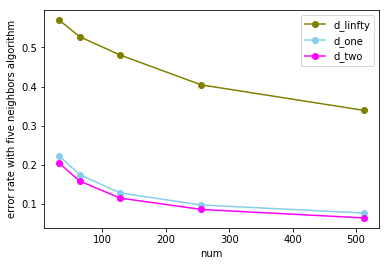

In [617]:
plot(x, res["d_linfty"], label="d_linfty", marker="o", color="olive")
plot(x, res["d_one"], label="d_one", marker="o", color="skyblue")
plot(x, res["d_two"], label="d_two", marker="o", color="magenta")
xlabel("num")
ylabel("error rate with five neighbors algorithm")
_ = legend()

As we can see, when moving from 1 to 3 neighbors, there is a substantial (and self-explanatory) increase in performance. On the other side, if we move from 3 to 5 neighbors the trajectories become very similar, which means that increasing the number of nearest neighbors in the query does not really yield a performance improvement after a certain number. In fact, we might speculate that the simplicity of the dataset is such that it becomes really easy to classify an image even considering only its really closest neighbors, instead of a whole bunch of neighbors. From what I could understand by viewing samples of the datasets, there are no "unclassifiable" images or wild outliers, making this a rather easy classification task even with few neighbors.